In [5]:
import math
import torch
import gpytorch
import pyro
from pyro.infer.mcmc import NUTS, MCMC
from matplotlib import pyplot as plt
import numpy as np 
from scipy.stats import multivariate_normal
import pandas as pd 

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
torch.backends.cudnn.enabled


True

In [6]:
torch.cuda.is_available()

False

# Uncertain Toolkit Tutorial 

We'll walk through some of the basics of this toolkit and show how it can be used to evaluate and visualize probabalistic models. 

In [4]:
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(-1, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
train_x = train_x.cuda()
train_y = train_y.cuda()
model = model.cuda()
likelihood = likelihood.cuda()

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [ ]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ), end='\r')
    optimizer.step()

In [8]:
test_y = torch.sin(test_x * (2 * math.pi)) + torch.randn(test_x.size()) * 0.2 
y = test_y.detach().squeeze().numpy()

In [9]:
s = output.rsample().detach().numpy()

res = {'ci':[], 'lower':[], 'upper':[], 'acc':[]}
for l in np.linspace(0,0.5,200):
    ci = 1 - 2*l
    mean = s.mean(axis=0)
    lower,upper = np.quantile(s, q=[l, 1-l], axis=0)
    
    acc = np.mean((y > lower) * (y < upper))

    res['ci'].append(ci)
    res['lower'].append(l)
    res['upper'].append(1-l)
    res['acc'].append(acc)

res = pd.DataFrame(res)
res.head()


ci     lower     upper       acc
0  1.000000  0.000000  1.000000  0.985075
1  0.994975  0.002513  0.997487  0.970149
2  0.989950  0.005025  0.994975  0.955224
3  0.984925  0.007538  0.992462  0.940299
4  0.979899  0.010050  0.989950  0.940299

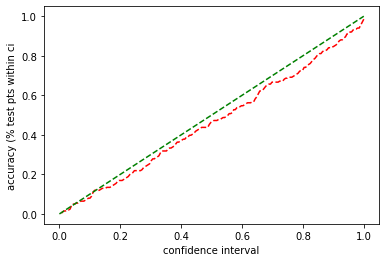

In [10]:
plt.figure()
plt.plot(res.ci, res.acc, 'r--')
plt.plot([0,1], [0,1], 'g--')
plt.ylabel('accuracy (% test pts within ci)')
plt.xlabel('confidence interval')
plt.show()

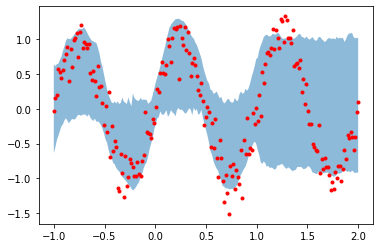

In [11]:
lower,upper = np.quantile(s, q=[0.05, 0.95], axis=0)

plt.figure()
plt.plot(test_x.detach().numpy(), test_y.detach().numpy(), 'r.')
plt.fill_between(test_x.numpy().squeeze(), lower, upper, alpha=0.5)
plt.show()

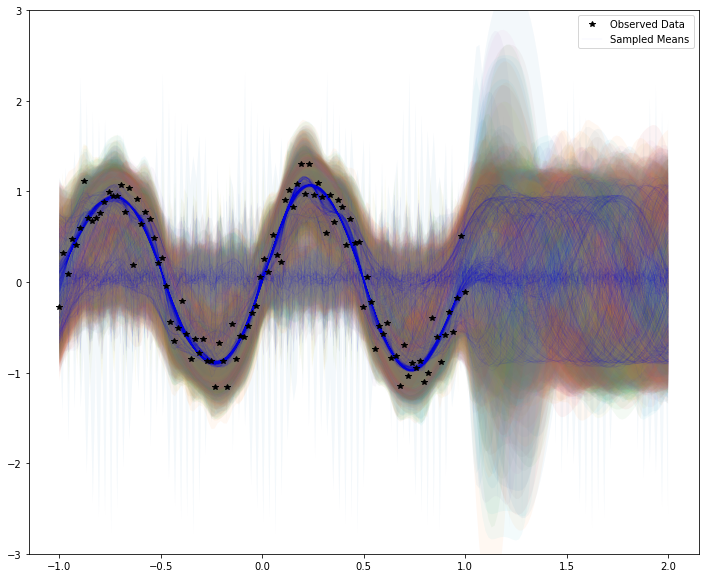

In [12]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(12, 10))

    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', zorder=10)

    for i in range(num_samples):
        # Plot predictive means as blue line
        mean, covar = output.mean[i].detach().numpy(), output.covariance_matrix[i].detach().numpy()
        sd = np.sqrt(np.diag(covar))
        lower = mean - 2*sd
        upper = mean + 2*sd

        ax.plot(test_x.numpy(), mean, 'b', linewidth=0.3, alpha=0.1)
        ax.fill_between(test_x.numpy().squeeze(), lower, upper, alpha=0.05)

    # Shade between the lower and upper confidence bound

    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Sampled Means'])

In [13]:
for l in np.linspace(0,1,10): 
    ci = (1-2*l

SyntaxError: unexpected EOF while parsing (<ipython-input-13-818cc83a8ff0>, line 2)